#About Dataset:
https://www.kaggle.com/datasets/ashkhagan/figshare-brain-tumor-dataset

https://figshare.com/articles/dataset/brain_tumor_dataset/1512427

- This brain tumor dataset containing 3064 T1-weighted contrast-inhanced images
from 233 patients with three kinds of brain tumor: meningioma (708 slices),
glioma (1426 slices), and pituitary tumor (930 slices).

- This data is organized in matlab data format (.mat file). Each file stores a struct
containing the following fields for an image:
1.   cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
2.   cjdata.PID: patient ID
3.   cjdata.image: image data
4.   cjdata.tumorBorder: a vector storing the coordinates of discrete points on tumor border.
5.   cjdata.tumorMask: a binary image with 1s indicating tumor region

#Summary
1- Load Data: Modified the function to read PNG images and their labels.

2- Define CNN Model: Created a simple CNN model using Keras.

3- Genetic Algorithm: Implemented a genetic algorithm to optimize the CNN model hyperparameters.

#**Importing necessary libraries**
---

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
import h5py
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import random

#**Data Loading and Preprocessing**
---

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'mahsaziaie'
os.environ['KAGGLE_KEY'] = 'kaggle datasets download -d ashkhagan/figshare-brain-tumor-dataset'

!kaggle datasets download -d ashkhagan/figshare-brain-tumor-dataset

import zipfile
with zipfile.ZipFile('figshare-brain-tumor-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('figshare-brain-tumor-dataset')

# List the files to verify
os.listdir('figshare-brain-tumor-dataset')

Dataset URL: https://www.kaggle.com/datasets/ashkhagan/figshare-brain-tumor-dataset
License(s): CC-BY-SA-4.0
100% 836M/839M [00:30<00:00, 24.1MB/s]
100% 839M/839M [00:30<00:00, 29.0MB/s]


['dataset']

In [ ]:
def load_data(dataset_path, target_size):
    """
    Data Loading and Preprocessing

    This function loads image data from .mat files in the specified directory, resizes the images if a target size is provided,
    and splits the data into training and testing sets. It also adjusts the labels to be zero-indexed.

    Parameters:
    - dataset_path: String path to the directory containing .mat files with image data and labels.
    - target_size: Tuple specifying the desired size to which images should be resized.

    Returns:
    - Tuple containing two elements:
      - (X_train, y_train): Numpy arrays for training images and labels.
      - (X_test, y_test): Numpy arrays for testing images and labels.
    """
    data_images = []
    data_labels = []
    print("\nLoading data...")

    for file_name in os.listdir(dataset_path):
        if file_name.endswith(".mat"):
            mat_file_path = os.path.join(dataset_path, file_name)
            with h5py.File(mat_file_path, 'r') as mat_file:
                image_data = np.array(mat_file['cjdata']['image'])
                label = int(mat_file['cjdata']['label'][0][0])

                if target_size:
                    image_data = cv2.resize(image_data, dsize=target_size, interpolation=cv2.INTER_CUBIC)

                # Expand dimensions to add channel dimension
                image_data = np.expand_dims(image_data, axis=-1)

                data_images.append(image_data)
                data_labels.append(label)

    data_images = np.array(data_images)
    data_labels = np.array(data_labels)
    print(f"\nLoaded {len(data_images)} images.")

    X_train, X_test, y_train, y_test = train_test_split(data_images, data_labels, test_size=0.2, random_state=42)
    print(f"\nSplit data: {len(X_train)} training samples, {len(X_test)} test samples.")

    y_train -= 1
    y_test -= 1

    return (X_train, y_train), (X_test, y_test)

#**Creating CNN Model**
---

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_cnn_model(params, input_shape, num_classes):
    """
    CNN Model Creation

    This function creates a Convolutional Neural Network (CNN) model based on the given parameters.
    It sets up a sequence of convolutional layers, max pooling layers, a flatten layer, and dense layers,
    and compiles the model with the Adam optimizer and categorical crossentropy loss.

    Parameters:
    - params: Dictionary containing parameters for the CNN model such as number of filters, dense units, and dropout rate.
    - input_shape: Tuple representing the shape of the input images (height, width, channels).
    - num_classes: Integer representing the number of output classes for classification.

    Returns:
    - Compiled CNN model.
    """
    print(f"Creating model with params: {params}")
    model = Sequential()

    # Adding Convolutional and Pooling Layers
    model.add(Conv2D(params.get('conv1_filters', 32), (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(params.get('conv2_filters', 64), (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(params.get('conv3_filters', 128), (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flattening and Dense Layers
    model.add(Flatten())
    model.add(Dense(params.get('dense_units', 256), activation='relu'))
    model.add(Dropout(params.get('dropout_rate', 0.2)))
    model.add(Dense(num_classes, activation='softmax'))

    # Compiling the Model
    model.compile(optimizer=Adam(learning_rate=params.get('learning_rate', 0.001)),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
def create_cnn_model(params, input_shape, num_classes):
    """
    CNN Model Creation

    This function creates a Convolutional Neural Network (CNN) model based on the given parameters.
    It sets up a sequence of convolutional layers, max pooling layers, a flatten layer, and dense layers,
    and compiles the model with the Adam optimizer and categorical crossentropy loss.

    Parameters:
    - params: Dictionary containing parameters for the CNN model such as number of filters, dense units, and dropout rate.
    - input_shape: Tuple representing the shape of the input images (height, width, channels).
    - num_classes: Integer representing the number of output classes for classification.

    Returns:
    - Compiled CNN model.
    """
    print(f"Creating model with params: {params}")
    model = Sequential()
    model.add(Conv2D(params['conv1_filters'], (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(params['conv2_filters'], (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(params['conv3_filters'], (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(params['dense_units'], activation='relu'))
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#**Genetic Algorithm Functions**
---

###Exploration

In [ ]:
def mutate_model_params(params):
    """
    Model Parameter Mutation

    This function creates a new set of model parameters by making small random changes to the given parameters.
    It adjusts float parameters (e.g., dropout rate) and integer parameters (e.g., number of filters).

    Parameters:
    - params: Dictionary containing the original model parameters to be mutated.

    Returns:
    - Dictionary with mutated model parameters.
    """
    mutated_params = params.copy()
    mutation_factor = 0.1
    for key in mutated_params:
        if isinstance(mutated_params[key], float):
            mutated_params[key] += mutation_factor * (random.random() - 0.5)
            if key == 'dropout_rate':
                mutated_params[key] = round(max(0.0, min(mutated_params[key], 0.999)), 2)
        elif isinstance(mutated_params[key], int):
            mutated_params[key] += random.randint(-1, 1)
            mutated_params[key] = max(1, mutated_params[key])
    return mutated_params

###Exploitation

In [ ]:
def crossover(parent1, parent2):
    """
    Crossover for Genetic Algorithm

    This function combines parameters from two parent models to create a child model. Each parameter is randomly
    chosen from one of the parents.

    Parameters:
    - parent1: Dictionary of parameters from the first parent model.
    - parent2: Dictionary of parameters from the second parent model.

    Returns:
    - Dictionary with parameters for the child model created by combining parameters from both parents.
    """
    child = {}
    for key in parent1:
        child[key] = parent1[key] if random.random() > 0.5 else parent2[key]
    return child

###Fitness Evaluation

In [ ]:
def evaluate_population(population, x_train, y_train, x_val, y_val, input_shape, num_classes):
    """
    Evaluate Population of Models

    This function evaluates a population of models by training each model on the training data and validating it
    on the validation data. It returns a sorted list of models based on their validation accuracy.

    Parameters:
    - population: List of dictionaries where each dictionary contains parameters for a model.
    - x_train: Numpy array of training images.
    - y_train: Numpy array of training labels.
    - x_val: Numpy array of validation images.
    - y_val: Numpy array of validation labels.
    - input_shape: Tuple representing the shape of input images.
    - num_classes: Integer representing the number of output classes.

    Returns:
    - List of tuples where each tuple contains the validation accuracy and the model parameters.
    """
    scores = []
    for i, params in enumerate(population):
        print(f"\nEvaluating model {i + 1}/{len(population)}")
        model = create_cnn_model(params, input_shape, num_classes)
        history = model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val), verbose=0)
        score = history.history['val_accuracy'][-1]
        scores.append((score, params))
        print(f"  - Model {i + 1} validation accuracy: {score:.4f}")
    scores.sort(reverse=True, key=lambda x: x[0])
    return scores

###Generating Population

In [ ]:
def create_initial_population(size, initial_params):
    """
    Create Initial Population

    This function generates an initial population of models by mutating a set of initial parameters.
    The size of the population is specified by the input parameter.

    Parameters:
    - size: Integer representing the number of models to generate.
    - initial_params: Dictionary containing the initial set of model parameters.

    Returns:
    - List of dictionaries, each representing a set of parameters for a CNN model.
    """
    print(f"\nCreating population of size {size}")
    population = [mutate_model_params(initial_params) for _ in range(size)]
    return population

#**Main Execution Pipeline**
---

In [ ]:
import time
start_time = time.time()

# Load data
dataset_path = "/content/figshare-brain-tumor-dataset/dataset/data"
target_size = (224, 224)
(x_train, y_train), (x_test, y_test) = load_data(dataset_path, target_size)

#Setting Up Training Parameters and Convert labels to one-hot encoded format
num_classes = 3
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
input_shape = x_train.shape[1:]

# Define initial model parameters
initial_params = {
    'conv1_filters': 32,
    'conv2_filters': 64,
    'conv3_filters': 128,
    'dense_units': 128,
    'dropout_rate': 0.4
}

# Create initial population
population_size = 10
population = create_initial_population(population_size, initial_params)

# Evaluate initial population
num_generations = 3
for generation in range(num_generations):
    print(f"\n\nGeneration {generation}:")
    scores = evaluate_population(population, x_train, y_train, x_test, y_test, input_shape, num_classes)
    print(f"    - Generation {generation} best score: {scores[0][0]:.4f}")
    top_individuals = scores[:population_size // 2]
    new_population = [crossover(random.choice(top_individuals)[1], random.choice(top_individuals)[1]) for _ in range(population_size)]
    new_population = [mutate_model_params(individual) for individual in new_population]
    population = new_population

best_params = scores[0][1]

# Train the best model
print(f"\nTraining the best model with params: {best_params}")
best_model = create_cnn_model(best_params, input_shape, num_classes)
best_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")

end_time = time.time()
print("\nExecution time: {:.2f} seconds".format(end_time - start_time))
execution_time_seconds = end_time - start_time
execution_time_minutes = execution_time_seconds / 60
print("Execution time: {:.2f} minutes".format(execution_time_minutes))


Loading data...

Loaded 3064 images.

Split data: 2451 training samples, 613 test samples.

Creating population of size 10


Generation 0:

Evaluating model 1/10
Creating model with params: {'conv1_filters': 32, 'conv2_filters': 63, 'conv3_filters': 128, 'dense_units': 127, 'dropout_rate': 0.43}
  - Model 1 validation accuracy: 0.9070

Evaluating model 2/10
Creating model with params: {'conv1_filters': 33, 'conv2_filters': 63, 'conv3_filters': 127, 'dense_units': 129, 'dropout_rate': 0.42}
  - Model 2 validation accuracy: 0.8842

Evaluating model 3/10
Creating model with params: {'conv1_filters': 31, 'conv2_filters': 64, 'conv3_filters': 129, 'dense_units': 127, 'dropout_rate': 0.4}
  - Model 3 validation accuracy: 0.8728

Evaluating model 4/10
Creating model with params: {'conv1_filters': 33, 'conv2_filters': 64, 'conv3_filters': 129, 'dense_units': 127, 'dropout_rate': 0.36}
  - Model 4 validation accuracy: 0.8891

Evaluating model 5/10
Creating model with params: {'conv1_filters': 

#**Generate predictions**
---

20/20 [==============================] - 0s 11ms/step


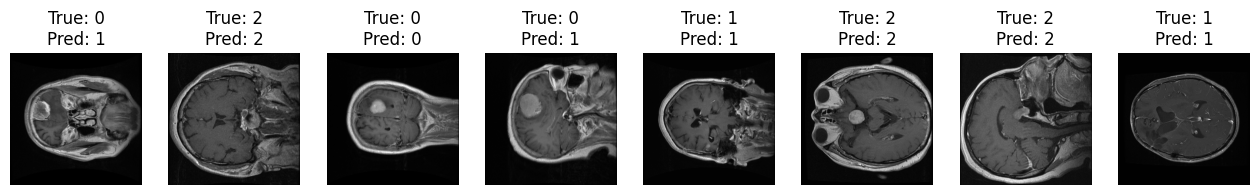

In [ ]:
import matplotlib.pyplot as plt
predictions = best_model.predict(x_test)

# Convert predictions from one-hot encoding to class labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

def display_samples(images, true_labels, predicted_labels, num_samples=5):
    plt.figure(figsize=(16, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')  # Remove channel dimension for display
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        plt.axis('off')
    plt.show()

display_samples(x_test, true_labels, predicted_labels, num_samples=8)